In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm
import time

%matplotlib inline

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Data preparation**

In [ ]:
SEQ_START = '<start>'
SEQ_END = '<end>'

In [ ]:
BASE = '/content/gdrive/My Drive/AI_yeeun/Datasets/flickr8k'

IMAGE_PATH = os.path.join(BASE, 'Flickr8k_Dataset')
CAPTION_PATH = os.path.join(BASE, 'Flickr8k_text')
CAPTION_FULL = os.path.join(CAPTION_PATH, 'Flickr8k.token.txt')

In [ ]:
os.listdir(BASE)

['Flickr8k_Dataset', 'Flickr8k_text']

In [ ]:
captions_map = defaultdict(list)
with open(CAPTION_FULL) as file:
    lines = file.readlines()
    for line in lines:
        data = line.split('\t')
        image_id = data[0].split('#')[0]
        caption = SEQ_START + ' ' + data[1].strip() + ' ' + SEQ_END
        if not os.path.exists(os.path.join(IMAGE_PATH, image_id + '.npy')):
            continue
        captions_map[image_id].append(caption)

In [ ]:
len(list(captions_map.keys()))

8091

In [ ]:
all_captions = []
all_image_paths = []
for image_id in captions_map:
    all_captions.extend(captions_map[image_id])
    all_image_paths.extend([os.path.join(IMAGE_PATH, image_id)] * len(captions_map[image_id]))

In [ ]:
all_captions[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [ ]:
all_image_paths[:5]

['/content/gdrive/My Drive/AI_yeeun/Datasets/flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/gdrive/My Drive/AI_yeeun/Datasets/flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/gdrive/My Drive/AI_yeeun/Datasets/flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/gdrive/My Drive/AI_yeeun/Datasets/flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/gdrive/My Drive/AI_yeeun/Datasets/flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg']

**Tokenize captions**

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(all_captions)

In [ ]:
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(inputs,
                                    r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

In [ ]:
# Parameters for tokenizer
MAX_LENGTH = 50
VOCAB_SIZE = 5000

# Tokenizer
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_LENGTH)

# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
caption_vectors = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
for cap in caption_vectors.take(1):
    print(cap)

tf.Tensor(
[  3   2  45   6   2  93 173   9 122  56   2 400  14 397   6  31   1 698
   5   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)


In [ ]:
word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

In [ ]:
# use for TF version < 2.8
def word2index(word):
    return tf.squeeze(word_to_index(tf.constant([word])))

def index2word(index):
    return tf.squeeze(index_to_word(tf.constant([index])))

**Image feature extraction**

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (260, 260))  # EfficientNetB2 expects this input shape
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

31790344/31790344 [==============================] - 3s 0us/step


In [ ]:
# Get unique images
unique_image_paths = sorted(set(all_image_paths))

**Split the data**

In [ ]:
image_to_caption_vectors = defaultdict(list)
for image_path, caption in zip(all_image_paths, caption_vectors):
    image_to_caption_vectors[image_path].append(caption)

In [ ]:
# Create training and validation sets using an 80-20 split randomly.
# image_keys = list(image_to_caption_vectors.keys())
random.shuffle(unique_image_paths)
slice_index = int(len(unique_image_paths) * 0.8)
train_paths, val_paths = unique_image_paths[:slice_index], unique_image_paths[slice_index:]

In [ ]:
image_train_paths =[]
caption_train = []
for path in train_paths:
    caption_len = len(image_to_caption_vectors[path])
    image_train_paths.extend([path] * caption_len)
    caption_train.extend(image_to_caption_vectors[path])

image_val_paths = []
caption_val = []
for path in val_paths:
    caption_len = len(image_to_caption_vectors[path])
    image_val_paths.extend([path] * caption_len)
    caption_val.extend(image_to_caption_vectors[path])

len(image_train_paths), len(caption_train), len(image_val_paths), len(caption_val)

(32360, 32360, 8095, 8095)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [ ]:
# Load the numpy files (pre-extracted features)
def map_func(image_path, caption):
    img_tensor = np.load(image_path.decode('utf-8') + '.npy')
    return img_tensor, caption

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((image_train_paths, caption_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
                            map_func, [item1, item2], [tf.float32, tf.int64]
                      )
                      , num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# **Create Model**

**Mask creator**

In [ ]:
def create_look_ahead_mask(sequence_length):
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask

def create_padding_mask(decoder_token_ids):
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)

    return seq[:, tf.newaxis, :]

**Positional Encoding**

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [ ]:
def positional_encoding_1d(position, D):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],  # column vector
                            np.arange(D)[np.newaxis, :],  # row vector
                            D)

    # Apply the sine function to even indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Apply the cosine function to odd indices
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def positional_encoding_2d(row, col, D):
    assert D % 2 == 0
    # first D/2 encode row embedding and second D/2 encode column embedding
    row_pos = np.repeat(np.arange(row), col)[:, np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col), 0), row, axis=0).reshape(-1, 1)

    angle_rads_row = get_angles(row_pos,
                                np.arange(D // 2)[np.newaxis, :],
                                D // 2)
    angle_rads_col = get_angles(col_pos,
                                np.arange(D // 2)[np.newaxis, :],
                                D // 2)

    # apply sin and cos to odd and even indices resp.
    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])

    pos_encoding = np.concatenate([angle_rads_row, angle_rads_col], axis=1)[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def point_wise_feed_forward_network(
    emb_dim,  # Input/output dimensionality (or Embedding dim)
    fc_dim  # Inner-layer dimensionality (or FC dim)
):

    return tf.keras.Sequential([
        # Shape `(batch_size, seq_len, fc_dim)`.
        tf.keras.layers.Dense(fc_dim, activation='relu'),
        # Shape `(batch_size, seq_len, emb_dim)`.
        tf.keras.layers.Dense(emb_dim)
    ])

**Encoder**

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, emb_dim, num_heads, fc_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderBlock, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                      key_dim=emb_dim,
                                                      dropout=dropout_rate)

        self.ffn = point_wise_feed_forward_network(emb_dim=emb_dim,
                                                   fc_dim=fc_dim)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        attn_output = self.mha(query=x, key=x, value=x,
                               training=training, attention_mask=mask)

        # (batch_size, input_seq_len, fully_connected_dim)
        out1 = self.layernorm1(attn_output + x, training=training)

        # (batch_size, input_seq_len, fully_connected_dim)
        ffn_output = self.ffn(out1, training=training)

        ffn_output = self.dropout1(ffn_output, training=training)

        # (batch_size, input_seq_len, fully_connected_dim)
        encoder_layer_out = self.layernorm2(ffn_output + out1, training=training)

        return encoder_layer_out

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 num_layers,
                 emb_dim,  # Input/output dimensionality (or Embedding dim).
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality (or FC dim).
                 row_size, col_size,    # Shape of grid features
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super().__init__()

        self.emb_dim = emb_dim
        self.num_layers = num_layers

        # Embeddings (it's just a Dense layer)
        self.embedding = tf.keras.layers.Dense(emb_dim, activation='relu')
        # Positional encoding 2D
        self.pos_encoding = positional_encoding_2d(row_size, col_size, emb_dim)

        # Encoder layers.
        self.enc_layers = [EncoderBlock(emb_dim=emb_dim,
                                        num_heads=num_heads,
                                        fc_dim=fc_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
            for _ in range(num_layers)]

        # Dropout.
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]

        # Sum up embeddings and positional encoding.
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]

        # Add dropout.
        x = self.dropout(x, training=training)

        # N encoder blocks.
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # Shape `(batch_size, input_seq_len, emb_dim)`.

**Decoder**

In [ ]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 emb_dim,  # Input/output dimensionality (or Embedding dim).
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality (or FC dim).
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super().__init__()

        # Masked multi-head self-attention.
        self.mha_masked = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            # Size of each attention head for query Q and key K.
            key_dim=emb_dim,
            dropout=dropout_rate
        )
        # Multi-head cross-attention.
        self.mha_cross = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            # Size of each attention head for query Q and key K.
            key_dim=emb_dim,
            dropout=dropout_rate
        )

        # Point-wise feed-forward network.
        self.ffn = point_wise_feed_forward_network(emb_dim, fc_dim)

        # Layer normalization.
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        # Dropout for the point-wise feed-forward network.
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # The encoder output shape is `(batch_size, input_seq_len, emb_dim)`.

        attn_masked, attn_weights_masked = self.mha_masked(
            query=x,
            value=x,
            key=x,
            # A boolean mask that prevents attention to certain positions.
            attention_mask=look_ahead_mask,
            # Shape `(batch_size, target_seq_len, emb_dim)`.
            return_attention_scores=True,
            training=training
        )

        out1 = self.layernorm1(attn_masked + x)

        attn_cross, attn_weights_cross = self.mha_cross(
            query=out1,
            value=enc_output,
            key=enc_output,
            # A boolean mask that prevents attention to certain positions.
            attention_mask=padding_mask,
            # Shape `(batch_size, target_seq_len, emb_dim)`.
            return_attention_scores=True,
            training=training
        )

        out2 = self.layernorm2(attn_cross + out1)

        # Shape `(batch_size, target_seq_len, emb_dim)`.
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout1(ffn_output, training=training)

        # Shape `(batch_size, target_seq_len, emb_dim)`.
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_masked, attn_weights_cross

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 num_layers,
                 emb_dim,  # Input/output dimensionality.
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality.
                 target_vocab_size,
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.emb_dim = emb_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(
            target_vocab_size,
            emb_dim,
            mask_zero=True
        )
        self.pos_encoding = positional_encoding_1d(MAX_LENGTH, emb_dim)

        self.dec_layers = [
            DecoderBlock(
                emb_dim=emb_dim,
                num_heads=num_heads,
                fc_dim=fc_dim,
                dropout_rate=dropout_rate,
                layernorm_eps=layernorm_eps)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Sum up embeddings and positional encoding.
        # Shape: `(batch_size, target_seq_len, emb_dim)`.
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.emb_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # The shape of x is `(batch_size, target_seq_len, emb_dim)`.
        return x, attention_weights

**Transformer**

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 *,
                 num_layers,  # Number of encoder and decoder layers.
                 emb_dim,  # Input/output dimensionality.
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality.
                 row_size, col_size,
                 target_vocab_size,
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super().__init__()
        # The encoder.
        self.encoder = Encoder(
            num_layers=num_layers,
            emb_dim=emb_dim,
            num_heads=num_heads,
            fc_dim=fc_dim,
            row_size=row_size,
            col_size=col_size,
            dropout_rate=dropout_rate,
            layernorm_eps=layernorm_eps
        )

        # The decoder.
        self.decoder = Decoder(
            num_layers=num_layers,
            emb_dim=emb_dim,
            num_heads=num_heads,
            fc_dim=fc_dim,
            target_vocab_size=target_vocab_size,
            dropout_rate=dropout_rate,
            layernorm_eps=layernorm_eps
        )

        # The final linear layer.
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, input, target, training, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        # The encoder output.
        # `(batch_size, inp_seq_len, emb_dim)`
        enc_output = self.encoder(input, training, enc_padding_mask)

        # The decoder output shape == (batch_size, tar_seq_len, emb_dim)
        dec_output, attention_weights = self.decoder(target, enc_output, training, look_ahead_mask, dec_padding_mask)

        # The final linear layer output.
        # Shape `(batch_size, tar_seq_len, target_vocab_size)`.
        final_output = self.final_layer(dec_output)

        # Return the final output and the attention weights.
        return final_output, attention_weights

**Initialize the model**

In [ ]:
num_layer = 4
emb_dim = 512
fc_dim = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = VOCAB_SIZE
dropout_rate = 0.1

In [ ]:
transformer = Transformer(num_layers=num_layer,
                          emb_dim=emb_dim,
                          num_heads=num_heads,
                          fc_dim=fc_dim,
                          row_size=row_size,
                          col_size=col_size,
                          target_vocab_size=VOCAB_SIZE,
                          dropout_rate=dropout_rate)

**Learning Rate**

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(emb_dim)

In [ ]:
optimizer = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.98, epsilon=1e-9)

**Loss function**

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

# **Train**

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
loss_plot = []

In [ ]:
@tf.function()
def train_step(input_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_padding_mask = None

    with tf.GradientTape() as tape:
        predictions, _ = transformer(input_tensor, tar_inp, True, None, look_ahead_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

In [ ]:
N_EPOCHS = 1

for epoch in range(N_EPOCHS):
    start = time.time()

    train_loss.reset_states()

    for (batch, (img_tensor, tar)) in enumerate(dataset):
        train_step(img_tensor, tar)

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, train_loss.result()))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    loss_plot.append(train_loss.result())

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

    print('------------------------------------')

Epoch 1 Batch 0 Loss 8.6261
Epoch 1 Batch 50 Loss 5.5169
Epoch 1 Batch 100 Loss 5.4152
Epoch 1 Batch 150 Loss 5.3623
Epoch 1 Batch 200 Loss 5.3355
Epoch 1 Batch 250 Loss 5.3178
Epoch 1 Batch 300 Loss 5.3040
Epoch 1 Batch 350 Loss 5.2903
Epoch 1 Batch 400 Loss 5.2837
Epoch 1 Batch 450 Loss 5.2768
Epoch 1 Batch 500 Loss 5.2726
Epoch 1 Loss 5.2725
Time taken for 1 epoch: 5675.969074249268 secs

------------------------------------


In [ ]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    decoder_input = tf.expand_dims([word2index(SEQ_START)], 0)
    result = []

    for i in range(MAX_LENGTH):
        look_ahead_mask = create_look_ahead_mask(tf.shape(decoder_input)[1])
        dec_padding_mask = None     # BUG: can't use padding mask for some unknown reasons.

        predictions, attention_weights = transformer(input=img_tensor_val,
                                                     target=decoder_input,
                                                     training=False,
                                                     look_ahead_mask=look_ahead_mask,
                                                     dec_padding_mask=dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.argmax(predictions, axis=-1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id[0][0].numpy() == word2index(SEQ_END):
            return result[:-1], attention_weights

        predicted_word = tf.compat.as_text(index2word(predicted_id[0][0].numpy()).numpy())
        result.append(predicted_word)
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    return result, attention_weights

# **Generate Captions**

In [ ]:
def generate(image_path):

    result, _ = evaluate(image_path)
    print('Prediction Caption:', ' '.join(result))
    plt.imshow(plt.imread(image_path))
    plt.show()

Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


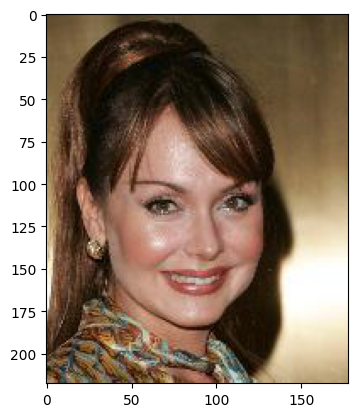

In [ ]:
img1='/content/gdrive/My Drive/AI_yeeun/Datasets/CelebAtest/000009.jpg'
generate(img1)

Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


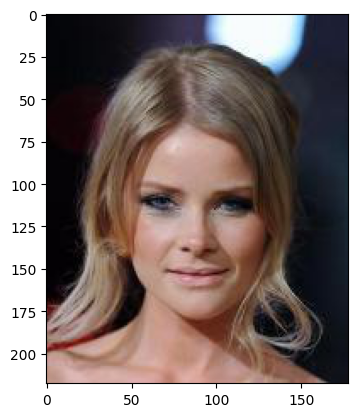

In [ ]:
img2='/content/gdrive/My Drive/AI_yeeun/Datasets/CelebAtest/000010.jpg'
generate(img2)

Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


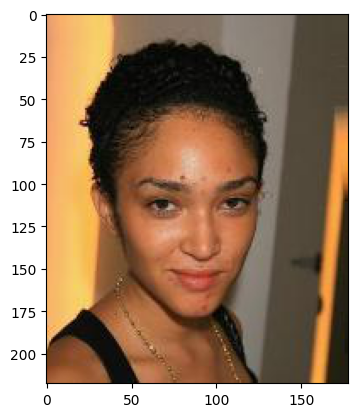

In [ ]:
img3='/content/gdrive/My Drive/AI_yeeun/Datasets/CelebAtest/000014.jpg'
generate(img3)

Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


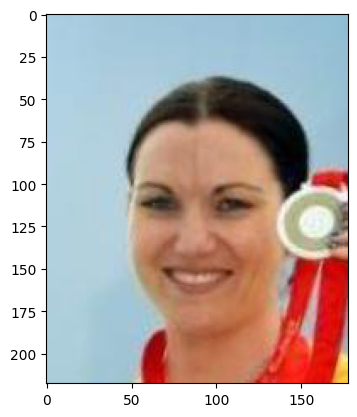

In [ ]:
img4='/content/gdrive/My Drive/AI_yeeun/Datasets/CelebAtest/000017.jpg'
generate(img4)

Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


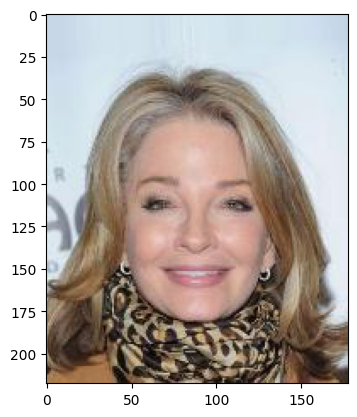

In [ ]:
img5='/content/gdrive/My Drive/AI_yeeun/Datasets/CelebAtest/000018.jpg'
generate(img5)

Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


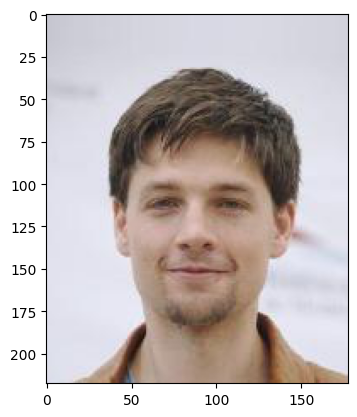

In [ ]:
img6='/content/gdrive/My Drive/AI_yeeun/Datasets/CelebAtest/000064.jpg'
generate(img6)

Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


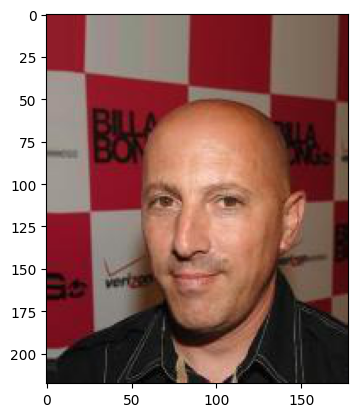

In [ ]:
img7='/content/gdrive/My Drive/AI_yeeun/Datasets/CelebAtest/000079.jpg'
generate(img7)

Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


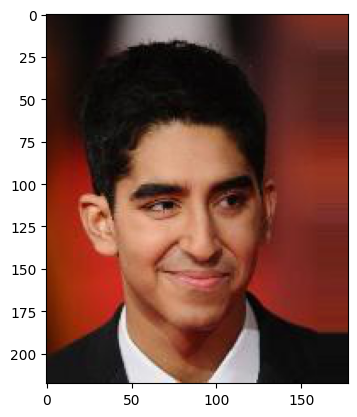

In [ ]:
img8='/content/gdrive/My Drive/AI_yeeun/Datasets/CelebAtest/000135.jpg'
generate(img8)

Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


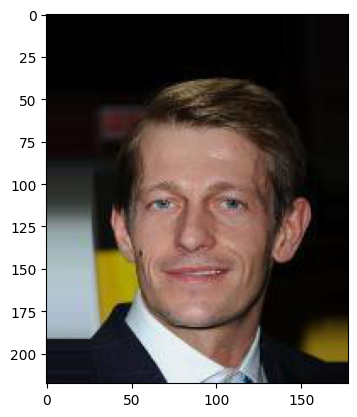

In [ ]:
img9='/content/gdrive/My Drive/AI_yeeun/Datasets/CelebAtest/000143.jpg'
generate(img9)

Prediction Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


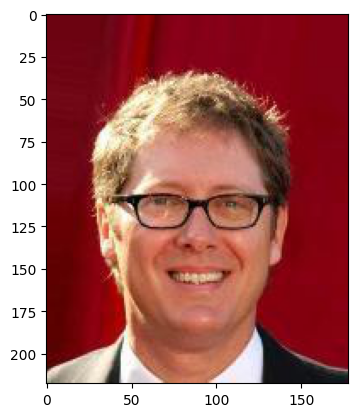

In [ ]:
img10='/content/gdrive/My Drive/AI_yeeun/Datasets/CelebAtest/000152.jpg'
generate(img10)